In [ ]:
%reset

In [1]:
%load_ext autoreload
%autoreload 1
%aimport cooking_session
%run cooking_session.py

In [2]:
# Packages
import pandas as pd
import numpy as np

In [3]:
# Source file
df_raw = pd.read_csv('dataframe_raw.csv', sep=',')

In [4]:
df_raw = remove_spikes(df_raw)

In [12]:
t_between = 15
min_active_load = 0.15
power_capacity = 1.0
time_resolution = 5
min_cooking_event = 0.05

In [13]:
df_processed = df_raw.copy()
df_processed.timestamp = pd.to_datetime(df_processed.timestamp)
df_processed.timestamp = np.int64(df_processed.timestamp)
df_processed.timestamp = pd.to_datetime(df_processed.timestamp)

# adding +3 hr to timestamp
df_processed.timestamp = df_processed.timestamp + pd.Timedelta(hours=3)
df_processed.timezone = 'UTC+03:00'

# creating indicators of when the EPC is considered to be online.
power_threshold = min_active_load * power_capacity
energy_threshold = power_threshold * time_resolution / 60

# (a): column of when a load is applied.

In [14]:
df_processed.loc[(
    (
        (df_processed.energy.diff() > energy_threshold)
        | (df_processed.power > min_active_load * power_capacity))
    & (df_processed.meter_number == df_processed.meter_number.shift())
), 'load'] = df_processed.energy.diff()

# (b): arrays for start & end

In [15]:
df_processed['cooking_start'] = False
df_processed['cooking_end'] = False

# (c): accumulated numbering of applied load instances.

In [16]:
df_processed['load_count'] = 0  # start
df_processed.loc[(df_processed.load.isnull()
                  == False), 'load_count'] += 1
df_processed.load_count = df_processed.load_count.cumsum()

# (d): timestamp of load instance

In [18]:
load_instance = df_processed.groupby('load_count').first()
load_instance.reset_index(inplace=True)
df_processed['timestamp_load'] = df_processed.load_count.map(
    load_instance.set_index('load_count')['timestamp'].to_dict())

# (e): creating a distinct list from the column meter_number and selecting the data as a sub-dataframe from df_processed for each meter_number to conduct the further analysis

In [19]:
df_processed.loc[(df_processed.meter_number.diff(-1) == 0),
                 'diff_next_timestamp'] = df_processed.timestamp.shift(-1) - df_processed.timestamp

df_processed.loc[(df_processed.meter_number.diff(-1) == 0),
                 'diff_prev_timestamp'] = df_processed.timestamp.diff()

##############################
# (f): defining cooking events

## (i): Cooking_start = TRUE: if timestamp_load - current timestamp is more than t_between and above energy_threshold OR new meter_number

In [20]:
df_processed.loc[
    (
        (
            (df_processed.timestamp -
             df_processed.timestamp_load.shift() > pd.to_timedelta(
                 t_between,
                 unit='m'))
            & (df_processed.energy.diff() >= energy_threshold))
        | (
            df_processed.meter_number != df_processed.meter_number.shift())
    ), 'cooking_start'] = True

In [21]:
df_processed.head(20)

,timestamp,id,meter_number,timezone,region,fetch_index,energy,voltage,current,power,power_factor,frequency,load,cooking_start,cooking_end,load_count,timestamp_load,diff_next_timestamp,diff_prev_timestamp
0,2020-03-10 21:50:00,311,546281,UTC+03:00,TZ cooking pilot,97,0.00,229.900000,0.000000,0.000000,1.000000,50.000000,NaN,True,False,0,2020-03-10 21:50:00,0 days 00:05:00,NaT
1,2020-03-10 21:55:00,311,546281,UTC+03:00,TZ cooking pilot,97,0.07,228.200000,4.301000,0.981488,0.999000,50.010000,0.07,False,False,1,2020-03-10 21:55:00,0 days 00:05:00,0 days 00:05:00
2,2020-03-10 22:00:00,311,546281,UTC+03:00,TZ cooking pilot,97,0.14,227.800000,4.309000,0.981590,0.998000,50.010000,0.07,False,False,2,2020-03-10 22:00:00,0 days 01:05:00,0 days 00:05:00
3,2020-03-10 23:05:00,311,546281,UTC+03:00,TZ cooking pilot,97,0.21,229.900000,0.000000,0.000000,1.000000,50.010000,0.07,True,False,3,2020-03-10 23:05:00,0 days 09:45:00,0 days 01:05:00
4,2020-03-11 08:50:00,311,546281,UTC+03:00,TZ cooking pilot,97,0.26,228.850000,2.153500,0.492828,0.999500,51.020000,0.05,True,False,4,2020-03-11 08:50:00,0 days 00:05:00,0 days 09:45:00
5,2020-03-11 08:55:00,311,546281,UTC+03:00,TZ cooking pilot,97,0.28,228.900000,2.167000,0.496026,0.558500,50.230000,0.02,False,False,5,2020-03-11 08:55:00,0 days 00:05:00,0 days 00:05:00
6,2020-03-11 09:00:00,311,546281,UTC+03:00,TZ cooking pilot,97,0.30,229.250000,2.170000,0.497472,0.999500,50.750000,0.02,False,False,6,2020-03-11 09:00:00,0 days 00:05:00,0 days 00:05:00
7,2020-03-11 09:05:00,311,546281,UTC+03:00,TZ cooking pilot,97,0.31,228.666667,4.328333,0.989746,0.999667,50.813333,0.01,False,False,7,2020-03-11 09:05:00,0 days 00:05:00,0 days 00:05:00
8,2020-03-11 09:10:00,311,546281,UTC+03:00,TZ cooking pilot,97,0.34,229.100000,3.946500,0.904143,0.998500,51.830000,0.03,False,False,8,2020-03-11 09:10:00,0 days 00:05:00,0 days 00:05:00
9,2020-03-11 09:15:00,311,546281,UTC+03:00,TZ cooking pilot,97,0.36,228.950000,2.158500,0.494189,0.999500,50.625000,0.02,False,False,9,2020-03-11 09:15:00,0 days 00:05:00,0 days 00:05:00


## (ii): Cooking_start = FALSE: if energy increase is above energy threshold and diff_prev_timestamp is less than t_between

In [22]:
df_processed.loc[
    (
        (df_processed.energy.diff() >= energy_threshold)
        & (df_processed.diff_prev_timestamp < pd.to_timedelta(t_between, unit='m'))
    ), 'cooking_start'] = False

In [23]:
df_processed.head(20)

,timestamp,id,meter_number,timezone,region,fetch_index,energy,voltage,current,power,power_factor,frequency,load,cooking_start,cooking_end,load_count,timestamp_load,diff_next_timestamp,diff_prev_timestamp
0,2020-03-10 21:50:00,311,546281,UTC+03:00,TZ cooking pilot,97,0.00,229.900000,0.000000,0.000000,1.000000,50.000000,NaN,True,False,0,2020-03-10 21:50:00,0 days 00:05:00,NaT
1,2020-03-10 21:55:00,311,546281,UTC+03:00,TZ cooking pilot,97,0.07,228.200000,4.301000,0.981488,0.999000,50.010000,0.07,False,False,1,2020-03-10 21:55:00,0 days 00:05:00,0 days 00:05:00
2,2020-03-10 22:00:00,311,546281,UTC+03:00,TZ cooking pilot,97,0.14,227.800000,4.309000,0.981590,0.998000,50.010000,0.07,False,False,2,2020-03-10 22:00:00,0 days 01:05:00,0 days 00:05:00
3,2020-03-10 23:05:00,311,546281,UTC+03:00,TZ cooking pilot,97,0.21,229.900000,0.000000,0.000000,1.000000,50.010000,0.07,True,False,3,2020-03-10 23:05:00,0 days 09:45:00,0 days 01:05:00
4,2020-03-11 08:50:00,311,546281,UTC+03:00,TZ cooking pilot,97,0.26,228.850000,2.153500,0.492828,0.999500,51.020000,0.05,True,False,4,2020-03-11 08:50:00,0 days 00:05:00,0 days 09:45:00
5,2020-03-11 08:55:00,311,546281,UTC+03:00,TZ cooking pilot,97,0.28,228.900000,2.167000,0.496026,0.558500,50.230000,0.02,False,False,5,2020-03-11 08:55:00,0 days 00:05:00,0 days 00:05:00
6,2020-03-11 09:00:00,311,546281,UTC+03:00,TZ cooking pilot,97,0.30,229.250000,2.170000,0.497472,0.999500,50.750000,0.02,False,False,6,2020-03-11 09:00:00,0 days 00:05:00,0 days 00:05:00
7,2020-03-11 09:05:00,311,546281,UTC+03:00,TZ cooking pilot,97,0.31,228.666667,4.328333,0.989746,0.999667,50.813333,0.01,False,False,7,2020-03-11 09:05:00,0 days 00:05:00,0 days 00:05:00
8,2020-03-11 09:10:00,311,546281,UTC+03:00,TZ cooking pilot,97,0.34,229.100000,3.946500,0.904143,0.998500,51.830000,0.03,False,False,8,2020-03-11 09:10:00,0 days 00:05:00,0 days 00:05:00
9,2020-03-11 09:15:00,311,546281,UTC+03:00,TZ cooking pilot,97,0.36,228.950000,2.158500,0.494189,0.999500,50.625000,0.02,False,False,9,2020-03-11 09:15:00,0 days 00:05:00,0 days 00:05:00


## (iii): Cooking_start = TRUE: if previous to current timestamp_load difference is above t_between + time_resolution AND power level is above 'power threshold', i.e. min_active_load * power_capacity

In [25]:
df_processed.loc[
    (
        (df_processed.timestamp_load.diff() > pd.to_timedelta(t_between + time_resolution, unit='m'))
        & (df_processed.power >= power_threshold)
    ), 'cooking_start'] = True

In [26]:
df_processed.head(20)

,timestamp,id,meter_number,timezone,region,fetch_index,energy,voltage,current,power,power_factor,frequency,load,cooking_start,cooking_end,load_count,timestamp_load,diff_next_timestamp,diff_prev_timestamp
0,2020-03-10 21:50:00,311,546281,UTC+03:00,TZ cooking pilot,97,0.00,229.900000,0.000000,0.000000,1.000000,50.000000,NaN,True,False,0,2020-03-10 21:50:00,0 days 00:05:00,NaT
1,2020-03-10 21:55:00,311,546281,UTC+03:00,TZ cooking pilot,97,0.07,228.200000,4.301000,0.981488,0.999000,50.010000,0.07,False,False,1,2020-03-10 21:55:00,0 days 00:05:00,0 days 00:05:00
2,2020-03-10 22:00:00,311,546281,UTC+03:00,TZ cooking pilot,97,0.14,227.800000,4.309000,0.981590,0.998000,50.010000,0.07,False,False,2,2020-03-10 22:00:00,0 days 01:05:00,0 days 00:05:00
3,2020-03-10 23:05:00,311,546281,UTC+03:00,TZ cooking pilot,97,0.21,229.900000,0.000000,0.000000,1.000000,50.010000,0.07,True,False,3,2020-03-10 23:05:00,0 days 09:45:00,0 days 01:05:00
4,2020-03-11 08:50:00,311,546281,UTC+03:00,TZ cooking pilot,97,0.26,228.850000,2.153500,0.492828,0.999500,51.020000,0.05,True,False,4,2020-03-11 08:50:00,0 days 00:05:00,0 days 09:45:00
5,2020-03-11 08:55:00,311,546281,UTC+03:00,TZ cooking pilot,97,0.28,228.900000,2.167000,0.496026,0.558500,50.230000,0.02,False,False,5,2020-03-11 08:55:00,0 days 00:05:00,0 days 00:05:00
6,2020-03-11 09:00:00,311,546281,UTC+03:00,TZ cooking pilot,97,0.30,229.250000,2.170000,0.497472,0.999500,50.750000,0.02,False,False,6,2020-03-11 09:00:00,0 days 00:05:00,0 days 00:05:00
7,2020-03-11 09:05:00,311,546281,UTC+03:00,TZ cooking pilot,97,0.31,228.666667,4.328333,0.989746,0.999667,50.813333,0.01,False,False,7,2020-03-11 09:05:00,0 days 00:05:00,0 days 00:05:00
8,2020-03-11 09:10:00,311,546281,UTC+03:00,TZ cooking pilot,97,0.34,229.100000,3.946500,0.904143,0.998500,51.830000,0.03,False,False,8,2020-03-11 09:10:00,0 days 00:05:00,0 days 00:05:00
9,2020-03-11 09:15:00,311,546281,UTC+03:00,TZ cooking pilot,97,0.36,228.950000,2.158500,0.494189,0.999500,50.625000,0.02,False,False,9,2020-03-11 09:15:00,0 days 00:05:00,0 days 00:05:00


## (iv): Cooking_end = TRUE: if difference between current timestamp and timestamp_load is above t_between AND power is above threshold on current and previous row AND same meter_number are all TRUE.  

In [27]:
df_processed.loc[
    (
        (df_processed.timestamp - df_processed.timestamp_load > pd.to_timedelta(
            t_between, unit='m'))
        & ((df_processed.power < power_threshold)
           & (df_processed.power.shift() < power_threshold)
           & (df_processed.meter_number == df_processed.meter_number.shift())
           )
        | (df_processed.energy - df_processed.energy.shift(-1) == 0)
    ), 'cooking_end'] = True

In [28]:
df_processed.head(20)

,timestamp,id,meter_number,timezone,region,fetch_index,energy,voltage,current,power,power_factor,frequency,load,cooking_start,cooking_end,load_count,timestamp_load,diff_next_timestamp,diff_prev_timestamp
0,2020-03-10 21:50:00,311,546281,UTC+03:00,TZ cooking pilot,97,0.00,229.900000,0.000000,0.000000,1.000000,50.000000,NaN,True,False,0,2020-03-10 21:50:00,0 days 00:05:00,NaT
1,2020-03-10 21:55:00,311,546281,UTC+03:00,TZ cooking pilot,97,0.07,228.200000,4.301000,0.981488,0.999000,50.010000,0.07,False,False,1,2020-03-10 21:55:00,0 days 00:05:00,0 days 00:05:00
2,2020-03-10 22:00:00,311,546281,UTC+03:00,TZ cooking pilot,97,0.14,227.800000,4.309000,0.981590,0.998000,50.010000,0.07,False,False,2,2020-03-10 22:00:00,0 days 01:05:00,0 days 00:05:00
3,2020-03-10 23:05:00,311,546281,UTC+03:00,TZ cooking pilot,97,0.21,229.900000,0.000000,0.000000,1.000000,50.010000,0.07,True,False,3,2020-03-10 23:05:00,0 days 09:45:00,0 days 01:05:00
4,2020-03-11 08:50:00,311,546281,UTC+03:00,TZ cooking pilot,97,0.26,228.850000,2.153500,0.492828,0.999500,51.020000,0.05,True,False,4,2020-03-11 08:50:00,0 days 00:05:00,0 days 09:45:00
5,2020-03-11 08:55:00,311,546281,UTC+03:00,TZ cooking pilot,97,0.28,228.900000,2.167000,0.496026,0.558500,50.230000,0.02,False,False,5,2020-03-11 08:55:00,0 days 00:05:00,0 days 00:05:00
6,2020-03-11 09:00:00,311,546281,UTC+03:00,TZ cooking pilot,97,0.30,229.250000,2.170000,0.497472,0.999500,50.750000,0.02,False,False,6,2020-03-11 09:00:00,0 days 00:05:00,0 days 00:05:00
7,2020-03-11 09:05:00,311,546281,UTC+03:00,TZ cooking pilot,97,0.31,228.666667,4.328333,0.989746,0.999667,50.813333,0.01,False,False,7,2020-03-11 09:05:00,0 days 00:05:00,0 days 00:05:00
8,2020-03-11 09:10:00,311,546281,UTC+03:00,TZ cooking pilot,97,0.34,229.100000,3.946500,0.904143,0.998500,51.830000,0.03,False,False,8,2020-03-11 09:10:00,0 days 00:05:00,0 days 00:05:00
9,2020-03-11 09:15:00,311,546281,UTC+03:00,TZ cooking pilot,97,0.36,228.950000,2.158500,0.494189,0.999500,50.625000,0.02,False,False,9,2020-03-11 09:15:00,0 days 00:05:00,0 days 00:05:00


## (v): Cooking_start = TRUE: if difference between current timestamp and timestamp_load is above t_between AND power above power_threshold 

In [29]:
df_processed.loc[
    (
        (df_processed.timestamp - df_processed.timestamp_load > pd.to_timedelta(
            t_between, unit='m'))
        & (df_processed.power >= power_threshold)
    ), 'cooking_start'] = True

In [ ]:
df_processed.head(20)

## (vi): Cooking_end = TRUE: if cooking_start in next row is TRUE OR new meter_number

In [30]:
df_processed.loc[
    (
        (df_processed.cooking_start.shift(-1))
        | (df_processed.meter_number != df_processed.meter_number.shift(-1))
    ), 'cooking_end'] = True

In [ ]:
df_processed.head(20)

## (vii): Cooking_end = TRUE: if cooking_end in next row is TRUE AND diff_next_timestamp is above t_between

In [31]:
df_processed.loc[
    (
        (df_processed.cooking_end.shift(-1))
        & (df_processed.diff_next_timestamp > pd.to_timedelta(t_between, unit='m'))
    ), 'cooking_end'] = True

In [ ]:
df_processed.head(20)

## (viii): Cooking_start = TRUE: if cooking_end on prev row AND cooking_end on current row

In [32]:
df_processed.loc[
    (
        (df_processed.cooking_end.shift())
        & (df_processed.cooking_end)
    ), 'cooking_start'] = True

In [ ]:
df_processed.head(20)

## (ix): Cooking_start = FALSE: if cooking_start on prev row AND cooking_start = TRUE in current row AND diff_prev_timestamp is less than t_between AND diff_next_timestamp is more than t_between.

In [33]:
df_processed.loc[
    (
        (df_processed.cooking_start.shift())
        & (df_processed.cooking_start)
        & (df_processed.diff_prev_timestamp <= pd.to_timedelta(
            t_between, unit='m'))
        & (df_processed.diff_next_timestamp > pd.to_timedelta(
            t_between, unit='m'))
    ), 'cooking_start'] = False

In [ ]:
df_processed.head(20)

## (x): Cooking_end = FALSE: if cooking_end on prev row AND cooking_end in current row == TRUE AND diff_prev_timestamp is more than t_between AND diff_next_timestamp is less than t_between.

In [34]:
df_processed.loc[
    (
        (df_processed.cooking_end.shift())
        & (df_processed.cooking_end)
        & (df_processed.diff_prev_timestamp > pd.to_timedelta(t_between, unit='m'))
        & (df_processed.diff_next_timestamp <= pd.to_timedelta(t_between, unit='m'))
    ), 'cooking_end'] = False

In [ ]:
df_processed.head(20)

## (xi): Cooking_start = FALSE: if cooking_start in prev row = TRUE AND cooking_start in current row = TRUE AND diff_prev_timestamp is less than t_between AND prev row has power above threshold.

In [35]:
df_processed.loc[
    (
        (df_processed.cooking_start.shift())
        & (df_processed.cooking_start)
        & (df_processed.diff_prev_timestamp < pd.to_timedelta(
            t_between, unit='m'))
        & (df_processed.power.shift() >= power_threshold)
    ), 'cooking_start'] = False

In [ ]:
df_processed.head(20)

## (xii): Cooking_end = TRUE: cooking_end is FALSE in previous and next row. Difference of current to next timestamp is above t_between.

In [36]:
df_processed.loc[
(
    (df_processed.cooking_end.shift(-1) == 0)
    & (df_processed.cooking_end.shift() == 0)
    & (df_processed.diff_next_timestamp > pd.to_timedelta(
        t_between, unit='m'))
), 'cooking_end'] = True

In [ ]:
df_processed.head(20)

## (xiii): if new meter number Cooking_end = FALSE

In [37]:
df_processed.loc[
    (df_processed.meter_number.diff() != 0), 'cooking_end'] = False

In [39]:
df_processed.head(20)

,timestamp,id,meter_number,timezone,region,fetch_index,energy,voltage,current,power,power_factor,frequency,load,cooking_start,cooking_end,load_count,timestamp_load,diff_next_timestamp,diff_prev_timestamp,cooking_event
0,2020-03-10 21:50:00,311,546281,UTC+03:00,TZ cooking pilot,97,0.00,229.900000,0.000000,0.000000,1.000000,50.000000,NaN,True,False,0,2020-03-10 21:50:00,0 days 00:05:00,NaT,1
1,2020-03-10 21:55:00,311,546281,UTC+03:00,TZ cooking pilot,97,0.07,228.200000,4.301000,0.981488,0.999000,50.010000,0.07,False,False,1,2020-03-10 21:55:00,0 days 00:05:00,0 days 00:05:00,1
2,2020-03-10 22:00:00,311,546281,UTC+03:00,TZ cooking pilot,97,0.14,227.800000,4.309000,0.981590,0.998000,50.010000,0.07,False,True,2,2020-03-10 22:00:00,0 days 01:05:00,0 days 00:05:00,1
3,2020-03-10 23:05:00,311,546281,UTC+03:00,TZ cooking pilot,97,0.21,229.900000,0.000000,0.000000,1.000000,50.010000,0.07,True,True,3,2020-03-10 23:05:00,0 days 09:45:00,0 days 01:05:00,2
4,2020-03-11 08:50:00,311,546281,UTC+03:00,TZ cooking pilot,97,0.26,228.850000,2.153500,0.492828,0.999500,51.020000,0.05,True,False,4,2020-03-11 08:50:00,0 days 00:05:00,0 days 09:45:00,3
5,2020-03-11 08:55:00,311,546281,UTC+03:00,TZ cooking pilot,97,0.28,228.900000,2.167000,0.496026,0.558500,50.230000,0.02,False,False,5,2020-03-11 08:55:00,0 days 00:05:00,0 days 00:05:00,3
6,2020-03-11 09:00:00,311,546281,UTC+03:00,TZ cooking pilot,97,0.30,229.250000,2.170000,0.497472,0.999500,50.750000,0.02,False,False,6,2020-03-11 09:00:00,0 days 00:05:00,0 days 00:05:00,3
7,2020-03-11 09:05:00,311,546281,UTC+03:00,TZ cooking pilot,97,0.31,228.666667,4.328333,0.989746,0.999667,50.813333,0.01,False,False,7,2020-03-11 09:05:00,0 days 00:05:00,0 days 00:05:00,3
8,2020-03-11 09:10:00,311,546281,UTC+03:00,TZ cooking pilot,97,0.34,229.100000,3.946500,0.904143,0.998500,51.830000,0.03,False,False,8,2020-03-11 09:10:00,0 days 00:05:00,0 days 00:05:00,3
9,2020-03-11 09:15:00,311,546281,UTC+03:00,TZ cooking pilot,97,0.36,228.950000,2.158500,0.494189,0.999500,50.625000,0.02,False,False,9,2020-03-11 09:15:00,0 days 00:05:00,0 days 00:05:00,3


##############################################
# (f): accumulated numbering of cooking events

In [38]:
df_processed['cooking_event'] = 0
df_processed.cooking_event += df_processed['cooking_start']
df_processed.cooking_event = df_processed['cooking_event'].cumsum()

# (g): get start & end timestamp of cooking events

In [40]:
start_cooking = df_processed.groupby('cooking_event').first()
start_cooking.reset_index(inplace=True)
df_processed['time_start'] = df_processed.cooking_event.map(
    start_cooking.set_index('cooking_event')['timestamp'].to_dict())
df_processed['energy_start'] = df_processed.cooking_event.map(
    start_cooking.set_index('cooking_event')['energy'].to_dict())

end_cooking = df_processed.copy()
end_cooking = end_cooking.loc[(end_cooking['cooking_end']==True)]
end_cooking = end_cooking.groupby(['cooking_event']).first()

end_cooking2 = df_processed.copy()
end_cooking2 = end_cooking2.groupby(['cooking_event']).last()
end_cooking = end_cooking.append(end_cooking2)
end_cooking.reset_index(inplace=True)
df_processed['time_end'] = df_processed.cooking_event.map(
    end_cooking.set_index('cooking_event')['timestamp'].to_dict())
df_processed['energy_end'] = df_processed.cooking_event.map(
    end_cooking.set_index('cooking_event')['energy'].to_dict())

df_processed.loc[((df_processed.timestamp > df_processed.time_end)
                  ), 'cooking_event'] = np.nan

df_processed.loc[((df_processed.timestamp > df_processed.time_end)
                  ), 'time_start'] = np.nan 

# (h): getting duration of cooking event and sequence time during cooking event

In [41]:
df_processed['cooking_time'] = (
    df_processed.time_end - df_processed.time_start) / np.timedelta64(1, 'm')
df_processed['seq_time'] = (
    df_processed.timestamp - df_processed.time_start) / np.timedelta64(1, 'm')

# (i): disqualifying too short cooking events

In [42]:
df_processed.loc[
    (
        (df_processed.cooking_event != df_processed.cooking_event.shift())
                  & (df_processed.cooking_event != df_processed.cooking_event.shift(-1))
                  & (df_processed.energy.diff() < min_cooking_event)
                  ), 'cooking_event'] = np.nan

# (j): disqualify too low energy cooking events

In [43]:
df_processed.loc[(
                  (df_processed.energy_end - df_processed.energy_start < min_cooking_event)
                  | ((df_processed.energy_end - df_processed.energy_start)/(df_processed.cooking_time/60) < 0.1)
                  ), 'cooking_event'] = np.nan

df_processed.set_index('timestamp', inplace=True)

df_processed.loc[((df_processed.cooking_event.isnull()  == True)
                  ), 'cooking_time'] = np.nan

df_processed.loc[((df_processed.cooking_event.isnull()  == True)
                  ), 'seq_time'] = np.nan 

In [44]:
df_epc = timestamp_issue(df_processed)

In [53]:
df_epc.head(20)

,id,meter_number,timezone,region,fetch_index,energy,voltage,current,power,power_factor,...,diff_next_timestamp,diff_prev_timestamp,cooking_event,time_start,energy_start,time_end,energy_end,cooking_time,seq_time,timestamp_issue
timestamp,,,,,,,,,,,,,,,,,,,,,
2020-03-10 21:50:00,311,546281,UTC+03:00,TZ cooking pilot,97,0.00,229.900000,0.000000,0.000000,1.000000,...,0 days 00:05:00,NaT,1.0,2020-03-10 21:50:00,0.00,2020-03-10 22:00:00,0.14,10.0,0.0,NaN
2020-03-10 21:55:00,311,546281,UTC+03:00,TZ cooking pilot,97,0.07,228.200000,4.301000,0.981488,0.999000,...,0 days 00:05:00,0 days 00:05:00,1.0,2020-03-10 21:50:00,0.00,2020-03-10 22:00:00,0.14,10.0,5.0,NaN
2020-03-10 22:00:00,311,546281,UTC+03:00,TZ cooking pilot,97,0.14,227.800000,4.309000,0.981590,0.998000,...,0 days 01:05:00,0 days 00:05:00,1.0,2020-03-10 21:50:00,0.00,2020-03-10 22:00:00,0.14,10.0,10.0,NaN
2020-03-10 23:05:00,311,546281,UTC+03:00,TZ cooking pilot,97,0.21,229.900000,0.000000,0.000000,1.000000,...,0 days 09:45:00,0 days 01:05:00,NaN,2020-03-10 23:05:00,0.21,2020-03-10 23:05:00,0.21,NaN,NaN,NaN
2020-03-11 08:50:00,311,546281,UTC+03:00,TZ cooking pilot,97,0.26,228.850000,2.153500,0.492828,0.999500,...,0 days 00:05:00,0 days 09:45:00,3.0,2020-03-11 08:50:00,0.26,2020-03-11 09:55:00,0.48,65.0,0.0,NaN
2020-03-11 08:55:00,311,546281,UTC+03:00,TZ cooking pilot,97,0.28,228.900000,2.167000,0.496026,0.558500,...,0 days 00:05:00,0 days 00:05:00,3.0,2020-03-11 08:50:00,0.26,2020-03-11 09:55:00,0.48,65.0,5.0,NaN
2020-03-11 09:00:00,311,546281,UTC+03:00,TZ cooking pilot,97,0.30,229.250000,2.170000,0.497472,0.999500,...,0 days 00:05:00,0 days 00:05:00,3.0,2020-03-11 08:50:00,0.26,2020-03-11 09:55:00,0.48,65.0,10.0,NaN
2020-03-11 09:05:00,311,546281,UTC+03:00,TZ cooking pilot,97,0.31,228.666667,4.328333,0.989746,0.999667,...,0 days 00:05:00,0 days 00:05:00,3.0,2020-03-11 08:50:00,0.26,2020-03-11 09:55:00,0.48,65.0,15.0,NaN
2020-03-11 09:10:00,311,546281,UTC+03:00,TZ cooking pilot,97,0.34,229.100000,3.946500,0.904143,0.998500,...,0 days 00:05:00,0 days 00:05:00,3.0,2020-03-11 08:50:00,0.26,2020-03-11 09:55:00,0.48,65.0,20.0,NaN


In [45]:
df_only_events = only_events(df_epc)

In [49]:
import matplotlib

<AxesSubplot:xlabel='timestamp'>

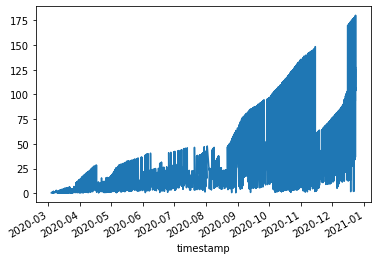

In [50]:
df_only_events.energy.plot()

In [51]:
df_only_events.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5338 entries, 2020-03-10 21:50:00 to 2020-04-01 20:25:00
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   meter_number   5338 non-null   int64  
 1   cooking_event  5338 non-null   float64
 2   energy         5338 non-null   float64
 3   energy_gen     5338 non-null   float64
 4   power          5338 non-null   float64
 5   cooking_time   5338 non-null   float64
 6   current        5338 non-null   float64
 7   no_recordings  5338 non-null   int64  
 8   id             5338 non-null   int64  
 9   power_mean     5338 non-null   float64
 10  cooking_cost   5338 non-null   float64
 11  event_count    5338 non-null   int64  
dtypes: float64(8), int64(4)
memory usage: 542.1 KB
